### Back-test gold/stocks/bonds

In [1]:
import numpy as np
from cvxopt import matrix
from cvxopt.solvers import qp as Solver, options as SolverOptions
from scipy.optimize import minimize_scalar
from scipy.optimize import minimize
import plotly.graph_objects as go
from scipy.stats import multivariate_normal as mvn
import pandas as pd

import quandl
quandl.ApiConfig.api_key = "f-5zoU2G4zzHaUtkJ7BY"

In [2]:
def tangency(means, cov, rf, short_lb):
    '''
    short_lb: lower bound on position weights
    examples: 0  = no short-selling
              -1 = no more than -100% in a given asset
              None=no restrictions on short-selling
    '''

    n = len(means)
    def f(w):
        mn = w @ means
        sd = np.sqrt(w.T @ cov @ w)
        return -(mn - rf) / sd
    # Initial guess (equal-weighted)
    w0 = (1/n)*np.ones(n)
    # Constraint: fully-invested portfolio
    A = np.ones(n)
    b = 1
    cons = [{"type": "eq", "fun": lambda x: A @ x - b}]
    bnds = [(short_lb, None) for i in range(n)] 
    # Optimization
    wgts_tangency = minimize(f, w0, bounds=bnds, constraints=cons).x
    return wgts_tangency
def gmv(cov, short_lb): 
    '''
    short_lb: lower bound on position weights
    examples: 0  = no short-selling
              -1 = no more than -100% in a given asset
              None=no restrictions on short-selling
    '''    
    n = len(cov)
    Q = matrix(cov, tc="d")
    p = matrix(np.zeros(n), (n, 1), tc="d")
    if short_lb==None:
        # No position limits
        G = matrix(np.zeros((n,n)), tc="d")
        h = matrix(np.zeros(n), (n, 1), tc="d")
    else:
        # Constraint: short-sales not allowed
        G = matrix(-np.identity(n), tc="d")
        h = matrix(-short_lb * np.ones(n), (n, 1), tc="d")
    # Fully-invested constraint
    A = matrix(np.ones(n), (1, n), tc="d")
    b = matrix([1], (1, 1), tc="d")
    sol = Solver(Q, p, G, h, A, b, options={'show_progress': False})
    wgts_gmv = np.array(sol["x"]).flatten() if sol["status"] == "optimal" else np.array(n * [np.nan])
    return wgts_gmv    

In [22]:
# Pull the data (from sbb.py and gold.py from website codebase)
# Stocks, bonds, bills
nominal = pd.read_csv('https://www.dropbox.com/s/hgwte6swx57jqcv/nominal_sbb.csv?dl=1', index_col=['Year'])

# Gold
d = quandl.get("LBMA/GOLD")['USD (AM)']
gold = d.resample('Y').last().iloc[:-1]
gold.index = [x.year for x in gold.index]
gold.loc[1967] = d.iloc[0]
gold = gold.sort_index().pct_change().dropna()
gold.name = 'Gold'
 

df = pd.concat((nominal, gold), axis=1).dropna()
assets = ['TBills','S&P 500', 'Gold', 'Corporates', 'Treasuries']
df = df[assets]

##### Inputs
# Window length (and initial period)
window = 20
n = len(assets)-1
raver = 5
short_lb = None
T = len(df)-window

In [23]:
# Rolling input estimation
risky = assets[1:]
df.columns = ['rf']+['r'+str(i) for i in range(n)]
asset_list = [str(i) for i in range(n)]
for asset in asset_list:
    df['mn' + asset]=df['r'+asset].rolling(window).mean()
    df['sd' + asset]=df['r'+asset].rolling(window).std()

ret_list = ['r' + asset for asset in asset_list]
corrs = df[ret_list].rolling(window, min_periods=window).corr()

corr_list = []
for j, asset in enumerate(asset_list):
    for k in range(j+1,n):
        df['c'+asset+str(k)]=corrs.loc[(slice(None),'r'+asset),'r'+str(k)].values
df['year'] = df.index
df = df.reset_index()


# Prepare columns for the rolling optimization output
model_list = ['ew', 'est_all', 'est_cov', 'est_sds']
for model in model_list:
    df['portret_'+model] = np.nan      #portret is the realized portfolio return of the 100% risky asset portfolio
    if model not in ['ew']:
        for asset in asset_list:
            df['wgt' + asset + '_' +model] = np.nan
    df['wgt_cal_'+model] =np.nan
    df['raver_portret_'+model] =np.nan #raver_portret_ is the realized return of the CAL choice of the raver investor

mn_list = ['mn'+asset for asset in asset_list]
sd_list = ['sd'+asset for asset in asset_list] 

# Choose optimal portfolios each time period
for i in np.arange(window,window+T):
    # Full estimation inputs at each point in time
    means = df[mn_list].iloc[i-1].values
    sds   = df[sd_list].iloc[i-1].values
    C  = np.identity(n)
    for j, asset in enumerate(asset_list):
        for k in range(j+1,n):
            C[j, k] = C[k, j] =    df.loc[i-1,'c'+asset+str(k)]  
    cov = np.diag(sds) @ C @ np.diag(sds)

    r = df.loc[i,'rf']
    ##### Note: all portfolio weights considered to be beginning of period weights
    ##### (so multiply by contemporaneous realized returns)
    # Full estimation tangency portfolio
    model = 'est_all'
    wgts = tangency(means,cov,r,short_lb)
    for j, asset in enumerate(asset_list):
        df.loc[i,'wgt'+asset+'_' + model] = wgts[j]
    df.loc[i,'portret_'+model] = df.loc[i,ret_list].values @ wgts
    df.loc[i,'wgt_cal_'+model] = (wgts @ means - r) / (raver * (wgts @ cov @ wgts))
    df.loc[i,'wgt_cal_'+model] = max(0,df.loc[i,'wgt_cal_'+model])
    df.loc[i,'raver_portret_'+model] = r + df.loc[i,'wgt_cal_'+model]  * (df.loc[i,'portret_'+model] -r)
    df.loc[i,'expret_'+model] = means @ wgts
    df.loc[i,'sd'+model] = np.sqrt(wgts @ cov @ wgts)

    # Estimate only covariance matrix
    model = 'est_cov'
    wgts = gmv(cov,short_lb)
    for j, asset in enumerate(asset_list):
        df.loc[i,'wgt'+asset+'_' + model] = wgts[j]
    df.loc[i,'portret_'+model] = df.loc[i,ret_list].values @ wgts
    df.loc[i,'wgt_cal_'+model] = (means.mean() - r) / (raver * (wgts @ cov @ wgts))
    df.loc[i,'wgt_cal_'+model] = max(0,df.loc[i,'wgt_cal_'+model])
    df.loc[i,'raver_portret_'+model] = r + df.loc[i,'wgt_cal_'+model]  * (df.loc[i,'portret_'+model] -r)
    df.loc[i,'expret_'+model] = means.mean()
    df.loc[i,'sd'+model] = np.sqrt(wgts @ cov @ wgts)

    # Estimate only standard deviations in covariance matrix
    model = 'est_sds'
    for j, asset in enumerate(asset_list):
        for k in range(j+1,n):
            cov[j, k] = cov[k, j] = 0.0
    wgts = gmv(cov,short_lb)
    for j, asset in enumerate(asset_list):
        df.loc[i,'wgt'+asset+'_' + model] = wgts[j]
    df.loc[i,'portret_'+model] = df.loc[i,ret_list].values @ wgts
    df.loc[i,'wgt_cal_'+model] = (means.mean() - r) / (raver * (wgts @ cov @ wgts))		
    df.loc[i,'wgt_cal_'+model] = max(0,df.loc[i,'wgt_cal_'+model])
    df.loc[i,'raver_portret_'+model] = r + df.loc[i,'wgt_cal_'+model]  * (df.loc[i,'portret_'+model] -r)    
    df.loc[i,'expret_'+model] = means.mean()
    df.loc[i,'sd'+model] = np.sqrt(wgts @ cov @ wgts)

    # Equal-weighted portfolio
    model = 'ew'
    for j, asset in enumerate(asset_list):
        cov[j,j] = (sds.mean())**2
    wgts = (1/n)*np.ones(n)
    df.loc[i,'portret_'+model] = df.loc[i,ret_list].values @ wgts
    df.loc[i,'wgt_cal_'+model] = (means.mean() - r) / (raver * (wgts @ cov @ wgts))
    df.loc[i,'wgt_cal_'+model] = max(0,df.loc[i,'wgt_cal_'+model])
    df.loc[i,'raver_portret_'+model] = r + df.loc[i,'wgt_cal_'+model]  * (df.loc[i,'portret_'+model] -r)   
    df.loc[i,'expret_'+model] = means.mean()
    df.loc[i,'sd'+model] = np.sqrt(wgts @ cov @ wgts)    

In [24]:
portret_list = ['raver_portret_' +  model for model in ['est_all', 'est_cov', 'est_sds','ew']]
stats = df[portret_list].describe()
stats

,raver_portret_est_all,raver_portret_est_cov,raver_portret_est_sds,raver_portret_ew
count,34.000000,34.000000,34.000000,34.000000
mean,0.298606,0.305746,0.317689,0.212242
std,0.406017,0.371266,0.331448,0.242597
min,-0.802216,-0.454778,-0.302823,-0.257604
25%,0.069471,0.135104,0.036213,0.035269
50%,0.351288,0.241430,0.347497,0.212161
75%,0.568270,0.453158,0.543779,0.309358
max,1.176866,1.045235,0.974309,0.701113


In [25]:
sr_df = pd.DataFrame(dtype=float, columns = ['sr','avg_ret','sd_ret'], index = ['est_all', 'est_cov', 'est_sds','ew'])
r = df[np.isnan(df['raver_portret_ew'])==False].rf.mean()
for model in ['est_all', 'est_cov', 'est_sds','ew']:
    sr_df.loc[model,'sr'] = (stats.loc['mean','raver_portret_' +  model] - r)/stats.loc['std','raver_portret_' +  model]
    sr_df.loc[model,'avg_ret'] = stats.loc['mean','raver_portret_' +  model]
    sr_df.loc[model,'sd_ret'] = stats.loc['std','raver_portret_' +  model]

label_dict = {'true': 'theoretical optimal weights', 
            'ew': 'equal weights',
            'est_all': 'estimate all inputs',
            'est_cov': 'estimate covariance matrix only',
            'est_sds': 'estimate standard deviations only'}

xaxis_label_dict = {'true': 'theoretical optimal weights', 
            'ew': 'Equal Weights',
            'est_all': 'Tangency',
            'est_cov': 'GMV',
            'est_sds': 'Risk Parity'}
sr_df = sr_df.reset_index()
sr_df['label'] = sr_df['index'].apply(lambda x: label_dict[x])
sr_df['xaxis_label'] = sr_df['index'].apply(lambda x: xaxis_label_dict[x])

In [26]:
df[np.isnan(df['raver_portret_ew'])==False].rf
sr_df

,index,sr,avg_ret,sd_ret,label,xaxis_label
0,est_all,0.666248,0.298606,0.406017,estimate all inputs,Tangency
1,est_cov,0.747840,0.305746,0.371266,estimate covariance matrix only,GMV
2,est_sds,0.873715,0.317689,0.331448,estimate standard deviations only,Risk Parity
3,ew,0.759052,0.212242,0.242597,equal weights,Equal Weights


In [27]:
import plotly.graph_objects as go

string ="Strategy: %{customdata[0]} <br>"
string += "Sharpe ratio: %{y:0.3f}<br>"
string += "Average return: %{customdata[1]:0.1%}<br>"
string += "SD(return): %{customdata[2]:0.1%}<br>"
string += "<extra></extra>"

fig = go.Figure()
fig.add_trace(go.Bar(x=sr_df['xaxis_label'], y=sr_df['sr'], customdata=sr_df[['label','avg_ret','sd_ret']], hovertemplate=string))
fig.layout.yaxis["title"] = "Sharpe ratio"
fig.layout.xaxis["title"] = "Strategy"
fig.show()

In [28]:
# Plot the time-series of returns and portfolio weights.
for asset in asset_list:
    df['wgt'+asset + '_ew'] = 1/n
label_dict = {'ew': 'equal weights',
            'est_all': 'estimate all inputs',
            'est_cov': 'estimate covariance matrix only',
            'est_sds': 'estimate standard deviations only'}
xaxis_label_dict = {'true': 'theoretical optimal weights', 
            'ew': 'Equal Weights',
            'est_all': 'Tangency',
            'est_cov': 'GMV',
            'est_sds': 'Risk Parity'}            

fig = go.Figure()
for model in ['est_all', 'est_cov', 'est_sds', 'ew']:
    string =  "Strategy: " + label_dict[model] +" <br>"
    string += "Year: %{x:4.0f}<br>"
    string += "Return: %{y:0.1%}<br>"
    string += "Weight in Risky Portfolio: %{customdata[0]: 0.1%} <br>"
    string += "Risky Portfolio Weights:<br>"
    string += "  "+ risky[0] +": %{customdata[1]: 0.1%} <br>"
    string += "  "+ risky[1] +": %{customdata[2]: 0.1%} <br>"
    string += "  "+ risky[2] +": %{customdata[3]: 0.1%} <br>"
    string += "  "+ risky[3] +": %{customdata[4]: 0.1%} <br>"
    string += "<extra></extra>"

    wgt_list = ['wgt_cal_'+ model] + ['wgt'+asset + "_" + model for asset in asset_list]
    trace=go.Scatter(x=df['year'], y=df['raver_portret_'+model], customdata=df[wgt_list], hovertemplate=string, name = xaxis_label_dict[model])
    fig.add_trace(trace)
fig.layout.yaxis["title"] = "Return"
fig.layout.xaxis["title"] = "Year"
fig.update_yaxes(tickformat=".0%")
fig.update_layout(legend=dict(yanchor="top", y =0.99, xanchor="left", x=0.01))
fig.update_xaxes(range=[df['year'].iloc[window], df.year.max()])
fig.show()

In [29]:
# Plot levereage (wgt_cal)
fig = go.Figure()
for model in ['est_all', 'est_cov', 'est_sds', 'ew']:
    string =  "Strategy: " + label_dict[model] +" <br>"
    string += "Year: %{x:4.0f}<br>"
    string += "Weight in Risky Portfolio: %{y: 0.1%} <br>"
    string += "<extra></extra>"

    trace=go.Scatter(x=df['year'], y=df['wgt_cal_'+model], hovertemplate=string, name = xaxis_label_dict[model])
    fig.add_trace(trace)
fig.layout.yaxis["title"] = "Risky Portfolio Weight"
fig.layout.xaxis["title"] = "Year"
fig.update_yaxes(tickformat=".0%")
fig.update_layout(legend=dict(yanchor="top", y =0.99, xanchor="left", x=0.01))
fig.update_xaxes(range=[df['year'].iloc[window], df.year.max()])
fig.show()

In [30]:
collist = ['wgt_cal_'+m for m in ['ew', 'est_all', 'est_cov', 'est_sds']]
df[['year']+collist]

,year,wgt_cal_ew,wgt_cal_est_all,wgt_cal_est_cov,wgt_cal_est_sds
0,1968,NaN,NaN,NaN,NaN
1,1969,NaN,NaN,NaN,NaN
2,1970,NaN,NaN,NaN,NaN
3,1971,NaN,NaN,NaN,NaN
4,1972,NaN,NaN,NaN,NaN
5,1973,NaN,NaN,NaN,NaN
6,1974,NaN,NaN,NaN,NaN
7,1975,NaN,NaN,NaN,NaN
8,1976,NaN,NaN,NaN,NaN
9,1977,NaN,NaN,NaN,NaN


In [159]:

for model in ['est_all', 'est_cov', 'est_sds']:
    collist = ['wgt' +asset +'_' +model for asset in asset_list]
    print(df[collist].describe().loc['mean'])

wgt0_est_all    0.127097
wgt1_est_all    0.060125
wgt2_est_all    1.274002
wgt3_est_all   -0.461224
Name: mean, dtype: float64
wgt0_est_cov    0.088549
wgt1_est_cov    0.127096
wgt2_est_cov    0.867950
wgt3_est_cov   -0.083595
Name: mean, dtype: float64
wgt0_est_sds    0.115357
wgt1_est_sds    0.086180
wgt2_est_sds    0.499172
wgt3_est_sds    0.299290
Name: mean, dtype: float64


In [165]:
assets[1:]

['S&P 500', 'Gold', 'Corporates', 'Treasuries']

In [168]:
# Full sample tangency
# Full estimation inputs at each point in time
means = df[mn_list].iloc[-1].values
sds   = df[sd_list].iloc[-1].values
C  = np.identity(n)
for j, asset in enumerate(asset_list):
    for k in range(j+1,n):
        C[j, k] = C[k, j] =    df['c'+asset+str(k)].iloc[-1]
cov = np.diag(sds) @ C @ np.diag(sds)

r = df['rf'].iloc[-1]
##### Note: all portfolio weights considered to be beginning of period weights
##### (so multiply by contemporaneous realized returns)
# Full estimation tangency portfolio
model = 'est_all'
wgts = tangency(means,cov,r,short_lb)

In [ ]:
df

In [32]:
df.to_csv("D:/bbcx-investments-quarto/quarto/kevin/sbb.csv")

In [ ]:
# Plot levereage (wgt_cal)
for model in ['est_all', 'est_cov', 'est_sds', 'ew']:
    wgt_list = ['wgt'+asset + "_" + model for asset in asset_list]
    df['expret_'+model] = np.nan
    for i in np.arange(window,window+T):
        means = df[mn_list].iloc[i-1].values
        wgts = df[wgt_list].iloc[i].values
        df.loc[i,'expret_'+model] = means @ wgts

# df['exp_ret'] = 
# fig = go.Figure()
# for model in ['est_all', 'est_cov', 'est_sds', 'ew']:
#     string =  "Strategy: " + label_dict[model] +" <br>"
#     string += "Year: %{x:4.0f}<br>"
#     string += "Weight in Risky Portfolio: %{y: 0.1%} <br>"
#     string += "<extra></extra>"

#     trace=go.Scatter(x=df['year'], y=df['wgt_cal_'+model], hovertemplate=string, name = xaxis_label_dict[model])
#     fig.add_trace(trace)
# fig.layout.yaxis["title"] = "Risky Portfolio Weight"
# fig.layout.xaxis["title"] = "Year"
# fig.update_yaxes(tickformat=".0%")
# fig.update_layout(legend=dict(yanchor="top", y =0.99, xanchor="left", x=0.01))
# fig.update_xaxes(range=[df['year'].iloc[window], df.year.max()])
# fig.show()
df[['expret_'+model for model in model_list]]

<AxesSubplot:>

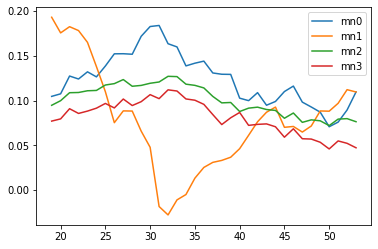

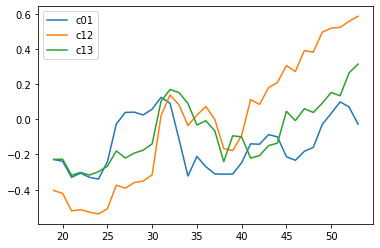

In [21]:
df[mn_list].plot()
df[['c01','c12','c13']].plot()